# TP cours - Comparez le comportement du lasso et de la régression ridge


expression gène du cancer = f(état du patient) 

In [1]:
data_path = "~/Documents/openclassroom/Fomation_ingenieur_ML/data/"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## sklearn module : 
from sklearn import model_selection 
from sklearn import preprocessing


In [2]:
df = pd.read_csv(data_path+"TP_1_prostate_dataset.txt", delimiter = "\t")
df.head()

,col,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
0,1,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,T
1,2,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,T
2,3,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,T
3,4,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,T
4,5,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,T


In [3]:
## DESIGN MATRICES : 
X = df.drop(["col", "lpsa","train"], axis = 1)
y = df.lpsa

## SPLIT DATA 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.7)

## STANDARDIZE : 
from sklearn.preprocessing import StandardScaler
my_std = preprocessing.StandardScaler()
my_std.fit(X_train)
X_train_std = my_std.transform(X_train)
X_test_std = my_std.transform(X_test)

# 1. Linear Regression : 

##### Model  : $\varepsilon \sim \mathcal{N}(0,\sigma^2)$
$$ y = X\beta + \varepsilon$$


##### Likelihood : 
$$ L = \prod_{i=1}^n \mathbb{P}[x^{(i)}, y^{(i)} | \beta ] $$
Max of log likelihood 
    $\Longleftrightarrow \underset{\beta \in  R^{p+1}}{\max} \left[  n \log(\frac{1}{\sigma \sqrt{2\pi}}) - \frac{1}{2\sigma^2} \sum_{i=1}^n  (f_{\beta}(x_i) - y_i )^2  \right]$
    $\Longleftrightarrow \underset{\beta \in  R^{p+1}}{\min} \left[ \sum_{i=1}^n  (f_{\beta}(x_i) - y_i )^2  \right]$


##### Least squares : 
Min of least squares : $ \underset{\beta \in  R^{p+1}}{\min} (y-X\beta)^T (y-X\beta)$ 

In [88]:
from sklearn import linear_model

lm_lr = linear_model.LinearRegression(copy_X=True, fit_intercept=True, 
                                   n_jobs=1, normalize=False)
lm_lr.fit(X_train_std,y_train)
y_pred = lm_lr.predict(X_test_std)
R2_lr = lm_lr.score(X_test_std, y_test)
R2_lr

0.5160513927554338

Mean Square Error : ("erreur quadratique moyenne")
$$ MSE = \frac{1}{n} \sum^n_{i=1} (f(x_i) - y_i)^2 $$

In [90]:
MSE_lr = ((y_pred-y_test)**2).mean()
MSE_lr

0.5207990235498341

We will need to define the score given by the MSE : 

In [111]:
## DEFINE MSE SCORE :
def MSE_fun(y_true, y_pred):
    return(mean_squared_error(y_true, y_pred))

## note that we could have used the sklearn.metrics.mean_squared_error as : 
# from sklearn.metrics import mean_squared_error
# MSE_fun = mean_squared_error


from sklearn.metrics import make_scorer
MSE_error = make_scorer(MSE_fun, greater_is_better=False)

MSE_fun(y_pred = y_pred,y_true = y_test)

0.5207990235498341

# Ridge Regression : 
Regularization of the coefficients : $ \|\beta \|_2^2 = 1$

The model is :
$$ y = X\beta + \varepsilon \text{ under constraint } \|\beta \|_2^2 = 1$$

KKT condition $\rightarrow$ lagrange multipliers $\rightarrow$ functionnal rewrites : 
$$\underset{\beta \in  R^{p+1}}{\min} (y-X\beta)^T (y-X\beta) + \alpha  \|\beta \|_2^2 $$

$\alpha$ is an hyperparameter $\rightarrow$ fitted with CV 

{'alpha': 12.067926406393289}

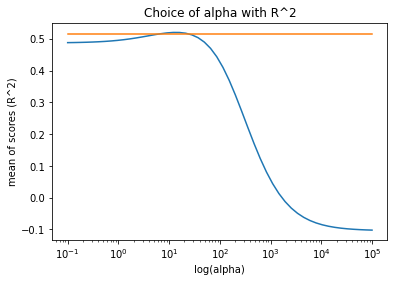

In [116]:
alpha_values = np.logspace(-1, 5, 50)
param_grid = {"alpha": alpha_values}

lm_ridge = linear_model.Ridge()

CV_ridge = model_selection.GridSearchCV(lm_ridge, param_grid= param_grid, cv = 5)
CV_ridge.fit(X_train_std, y_train)

ax = plt.gca()
ax.set_xscale("log")
ax.plot(alpha_values,CV_ridge.cv_results_['mean_test_score'],
        [alpha_values[0],alpha_values[-1]], [R2_lr, R2_lr])
plt.xlabel("log(alpha)")
plt.ylabel("mean of scores (R^2)")
plt.title("Choice of alpha with R^2")
plt.plot()

CV_ridge.best_params_

In [117]:
kwargs = CV_ridge.best_params_
lm_ridge = linear_model.Ridge(**kwargs)
lm_ridge.fit(X_train, y_train)

y_pred = lm_ridge.predict(X_test_std)

In the course, the score considered is not the $R^2$ as in the sklearn method, but the Mean Square Error. Let's implement our MSE score in the CV : 

{'alpha': 8.286427728546842}

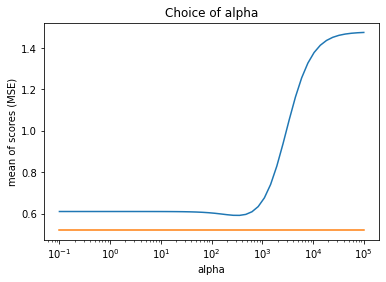

In [127]:
## USE MSE SCORE IN CV : 
param_grid = {"alpha":np.logspace(-5,5,50)}
lm_ridge = linear_model.Ridge()

CV_ridge = model_selection.GridSearchCV(lm_ridge, param_grid = param_grid, 
                                        scoring = MSE_score, cv = 5)
CV_ridge.fit(X_train_std, y_train)

ax = plt.gca()
ax.set_xscale("log")
ax.plot(alpha_values,-CV_ridge.cv_results_['mean_test_score'],
        [alpha_values[0],alpha_values[-1]], [MSE_lr, MSE_lr])
plt.xlabel("alpha")
plt.ylabel("mean of scores (MSE)")
plt.title("Choice of alpha")
plt.plot()

CV_ridge.best_params_

In [110]:
CV_ridge.cv_results_["mean_test_score"]

array([-0.61058662, -0.61058657, -0.61058649, -0.61058636, -0.61058615,
       -0.61058581, -0.61058528, -0.61058442, -0.61058304, -0.61058084,
       -0.61057733, -0.6105717 , -0.6105627 , -0.61054831, -0.61052531,
       -0.61048856, -0.61042991, -0.61033641, -0.6101877 , -0.60995199,
       -0.60958044, -0.60899996, -0.60810575, -0.6067588 , -0.60480063,
       -0.60210985, -0.59873251, -0.59509717, -0.59224679, -0.59194296,
       -0.59661068, -0.60936969, -0.63431387, -0.67655152, -0.74103568,
       -0.82964663, -0.93776114, -1.05370394, -1.1631775 , -1.25549268,
       -1.32654763, -1.37763147, -1.41263162, -1.43584324, -1.45091025,
       -1.4605559 , -1.4666765 , -1.47053861, -1.47296701, -1.47449055])

In [43]:

ax = plt.gca()
ax.plot(alpha_values,  )
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

Help on class GridSearchCV in module sklearn.model_selection._search:

class GridSearchCV(BaseSearchCV)
 |  GridSearchCV(estimator, param_grid, *, scoring=None, n_jobs=None, iid='deprecated', refit=True, cv=None, verbose=0, pre_dispatch='2*n_jobs', error_score=nan, return_train_score=False)
 |  
 |  Exhaustive search over specified parameter values for an estimator.
 |  
 |  Important members are fit, predict.
 |  
 |  GridSearchCV implements a "fit" and a "score" method.
 |  It also implements "predict", "predict_proba", "decision_function",
 |  "transform" and "inverse_transform" if they are implemented in the
 |  estimator used.
 |  
 |  The parameters of the estimator used to apply these methods are optimized
 |  by cross-validated grid-search over a parameter grid.
 |  
 |  Read more in the :ref:`User Guide <grid_search>`.
 |  
 |  Parameters
 |  ----------
 |  estimator : estimator object.
 |      This is assumed to implement the scikit-learn estimator interface.
 |      Either e

In [42]:
help(linear_model.RidgeCV())

Help on RidgeCV in module sklearn.linear_model._ridge object:

class RidgeCV(sklearn.base.MultiOutputMixin, sklearn.base.RegressorMixin, _BaseRidgeCV)
 |  RidgeCV(alphas=(0.1, 1.0, 10.0), *, fit_intercept=True, normalize=False, scoring=None, cv=None, gcv_mode=None, store_cv_values=False)
 |  
 |  Ridge regression with built-in cross-validation.
 |  
 |  See glossary entry for :term:`cross-validation estimator`.
 |  
 |  By default, it performs Generalized Cross-Validation, which is a form of
 |  efficient Leave-One-Out cross-validation.
 |  
 |  Read more in the :ref:`User Guide <ridge_regression>`.
 |  
 |  Parameters
 |  ----------
 |  alphas : ndarray of shape (n_alphas,), default=(0.1, 1.0, 10.0)
 |      Array of alpha values to try.
 |      Regularization strength; must be a positive float. Regularization
 |      improves the conditioning of the problem and reduces the variance of
 |      the estimates. Larger values specify stronger regularization.
 |      Alpha corresponds to ``